# BasicTS + GP

In [1]:
import matplotlib.pyplot as plt
from utils import *
path= '27d40957374f98d2d16be997f2c114de'
runner = init(model='PatchTST', dataset='ETTh1_prob', path=path, no_logging=False)

2025-03-13 15:41:10,881 - easytorch-launcher - INFO - Initializing runner "<class 'basicts.runners.runner_zoo.simple_prob_tsf_runner.SimpleProbTimeSeriesForecastingRunner'>"
2025-03-13 15:41:10,882 - easytorch-env - INFO - Disable TF32 mode
2025-03-13 15:41:10,882 - easytorch - INFO - Set ckpt save dir: 'checkpoints/i_quantile_PatchTST/ETTh1_100_336_96/3a7b29c3e24b0a9be4c0d8c1b41862bd'
2025-03-13 15:41:10,883 - easytorch - INFO - Building model.


DESCRIPTION: An Example Config
GPU_NUM: 1
RUNNER: <class 'basicts.runners.runner_zoo.simple_prob_tsf_runner.SimpleProbTimeSeriesForecastingRunner'>
DATASET:
  NAME: ETTh1
  TYPE: <class 'basicts.data.simple_tsf_dataset.TimeSeriesForecastingDataset'>
  PARAM:
    dataset_name: ETTh1
    train_val_test_ratio: [0.6, 0.2, 0.2]
    input_len: 336
    output_len: 96
SCALER:
  TYPE: <class 'basicts.scaler.z_score_scaler.ZScoreScaler'>
  PARAM:
    dataset_name: ETTh1
    train_ratio: 0.6
    norm_each_channel: True
    rescale: False
MODEL:
  NAME: PatchTST
  ARCH: <class 'baselines.PatchTST.arch.patchtst_arch.PatchTST'>
  PARAM:
    enc_in: 7
    seq_len: 336
    pred_len: 96
    e_layers: 3
    n_heads: 4
    d_model: 16
    d_ff: 128
    dropout: 0.3
    fc_dropout: 0.3
    head_dropout: 0.0
    patch_len: 16
    stride: 8
    individual: 1
    padding_patch: end
    revin: 0
    affine: 0
    subtract_last: 0
    decomposition: 0
    kernel_size: 25
    head_type: probabilistic
    distri

2025-03-13 15:41:11,218 - easytorch-training - INFO - Initializing training.
2025-03-13 15:41:11,219 - easytorch-training - INFO - Set clip grad, param: {'max_norm': 5.0}
2025-03-13 15:41:11,219 - easytorch-training - INFO - Building training data loader.
2025-03-13 15:41:11,222 - easytorch-training - INFO - Train dataset length: 8209
2025-03-13 15:41:12,324 - easytorch-training - INFO - Set optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0.0001
)
2025-03-13 15:41:12,326 - easytorch-training - INFO - Set lr_scheduler: <torch.optim.lr_scheduler.MultiStepLR object at 0x7ff3131cb510>
2025-03-13 15:41:12,326 - easytorch-training - INFO - Load model from : /home/kreffert/Probabilistic_LTSF/BasicTS/checkpoints/i_quantile_PatchTST/ETTh1_100_336_96/27d40957374f98d2d16be997f2c114de
2025-03-13 15:41:12,328 - easytorch-tra

[0.0001, 0.5, 0.9999]
[0.0001, 0.5, 0.9999]


39it [00:00, 40.84it/s]


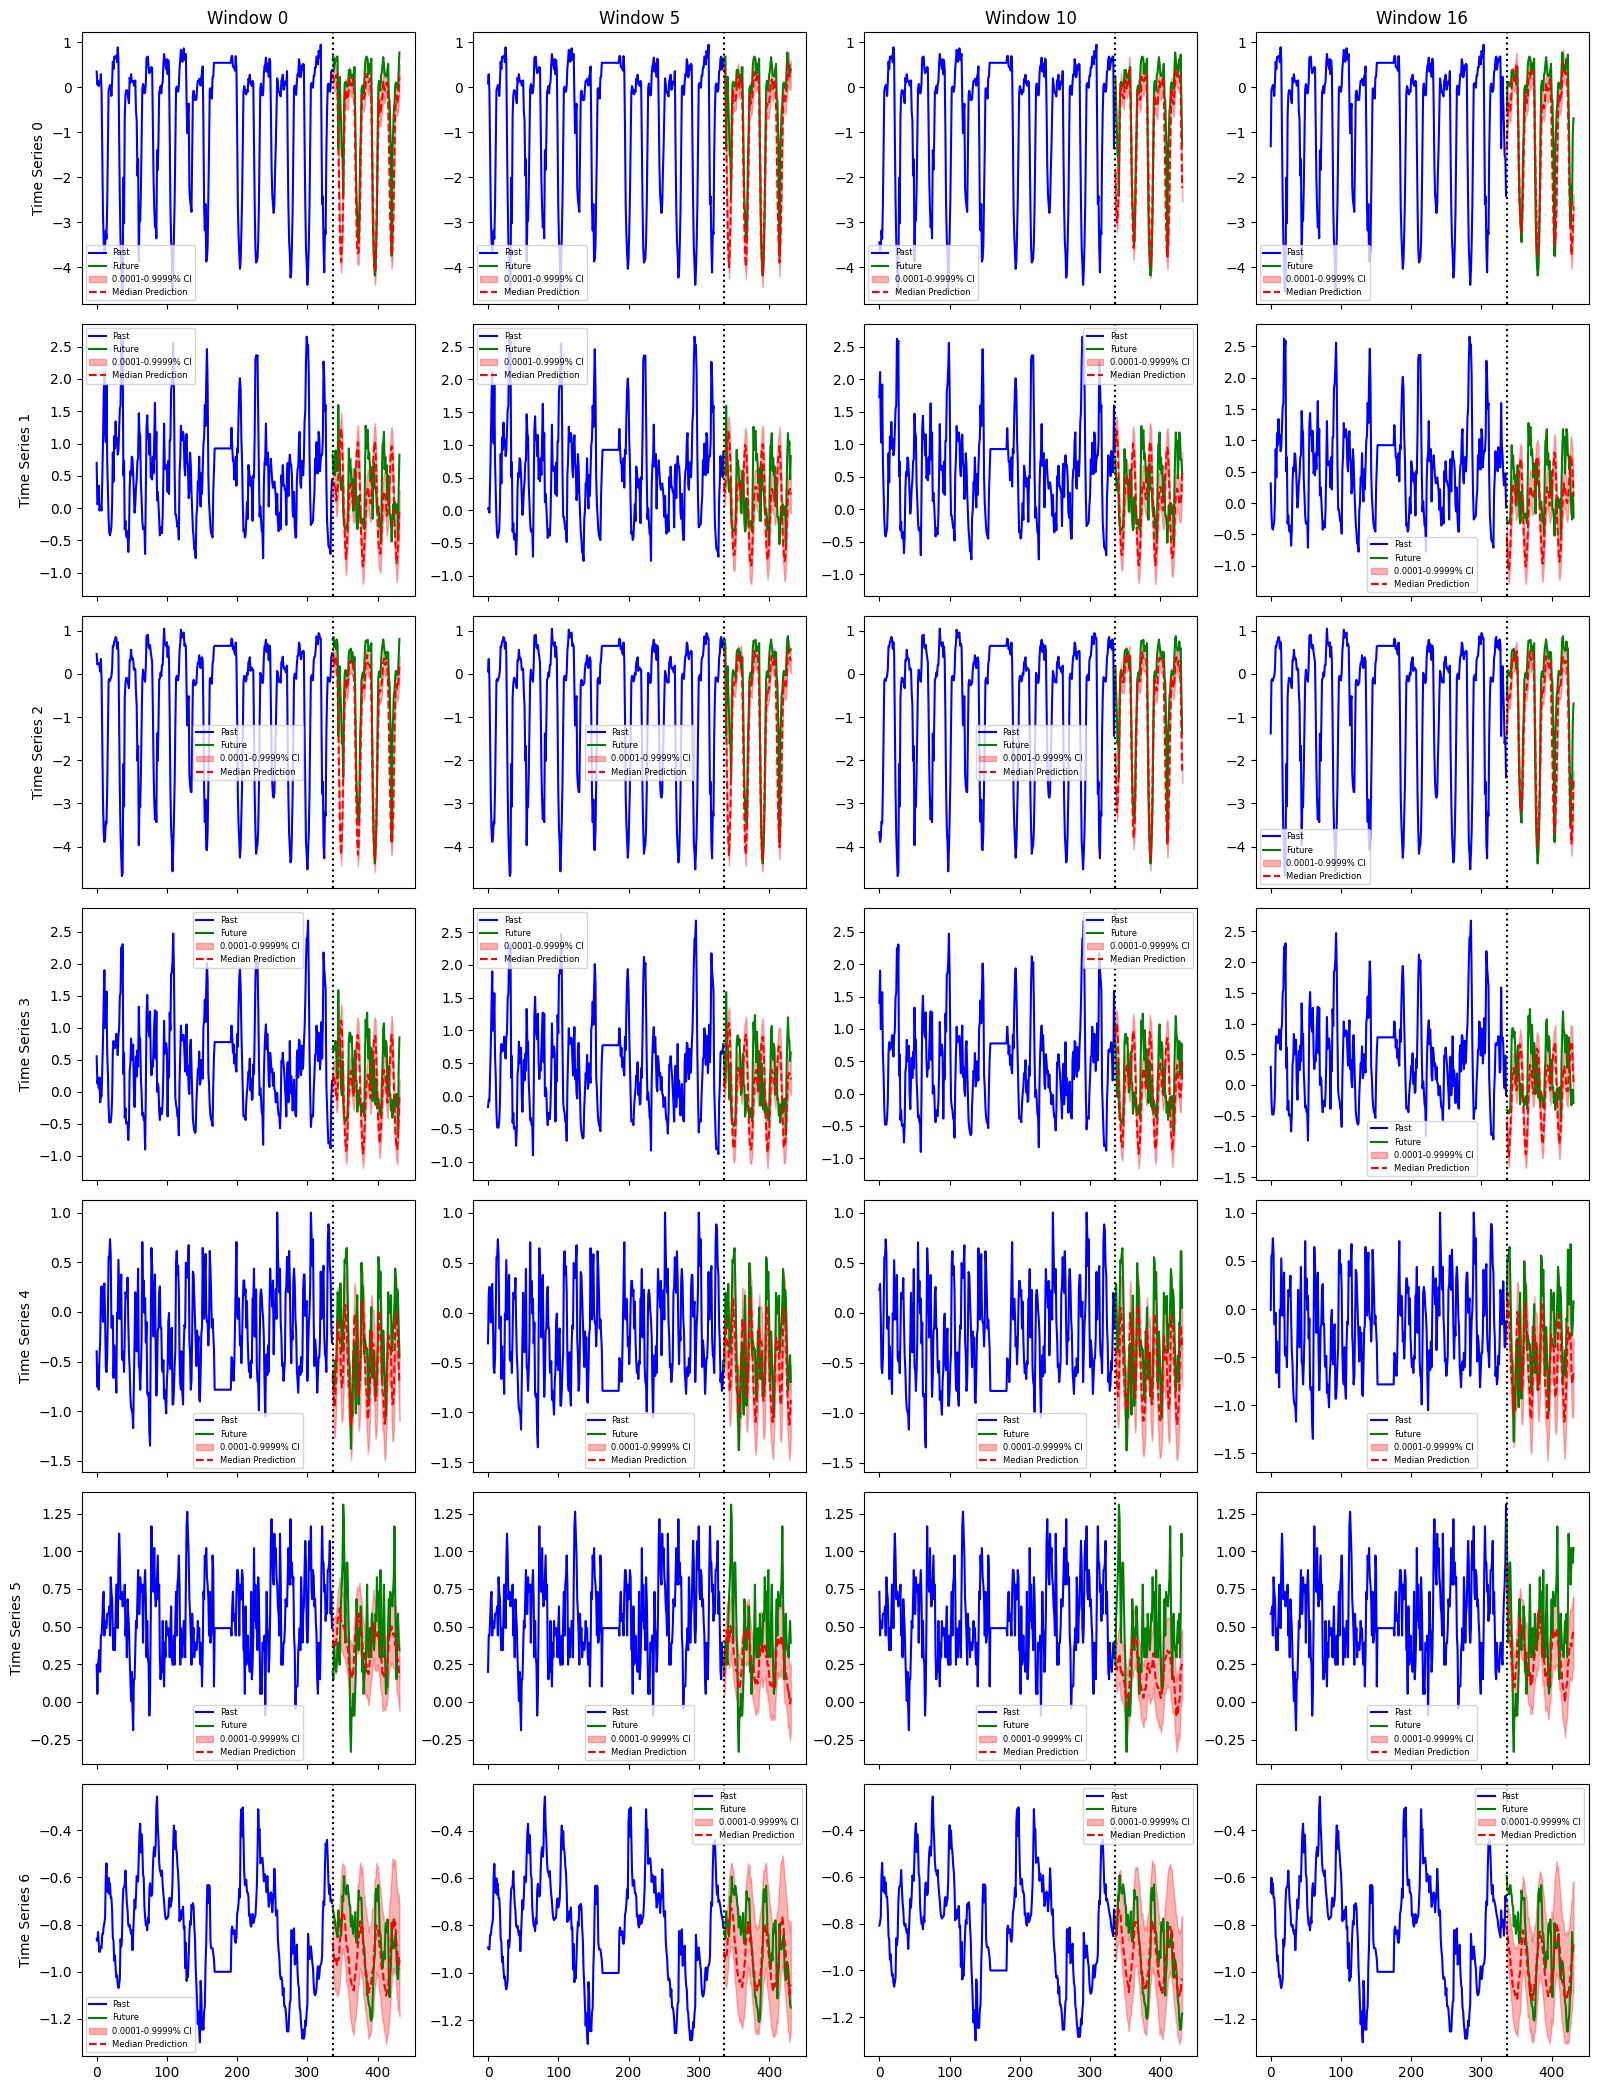

In [5]:
def plot_time_series_1(past_actuals, future_actuals, predictions, windows, series, ci=[5, 95], quantile_levels=[]):
    num_rows = len(series)  # One row per feature
    num_cols = len(windows)  # One column per time series index

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 3), sharex=True, sharey=False)

    if num_rows == 1 or num_cols == 1:
        axes = np.array(axes).reshape(num_rows, num_cols)  # Ensure 2D indexing

    for row, serie in enumerate(series):
        for col, window in enumerate(windows):
            ax = axes[row, col]  # Get the correct subplot

            # Plot past actuals
            ax.plot(range(len(past_actuals[window])), past_actuals[window, :, serie], label="Past", color='blue')

            # Plot future actuals
            ax.plot(range(len(past_actuals[window]), len(past_actuals[window]) + len(future_actuals[window])),
                    future_actuals[window, :, serie], label="Future", color='green')

            if ci != None:
                if len(quantile_levels)>1:# quantile forecast
                    ci = [i / 100 if i > 1 else i for i in ci]
                    assert ci[0] in quantile_levels
                    assert ci[1]in quantile_levels
                    assert 0.5 in quantile_levels 
                    lower_bound = predictions[window, :, serie, quantile_levels.index(ci[0])]
                    upper_bound = predictions[window, :, serie, quantile_levels.index(ci[1])]
                    median_pred = predictions[window, :, serie, quantile_levels.index(0.5)]
                else:# non quantile prob forecast -> need to calculate the quantiles first
                    # Extract mean and std
                    median_pred = predictions[window, :, serie, 0]  # Shape: [num_time_steps]
                    std = predictions[window, :, serie, 1]   # Shape: [num_time_steps]
                    
                    # Create a grid of x values
                    #x = range(predictions.shape[1])
                    # Compute the PDFs for all time steps at once
                    #pdfs = norm.pdf(x, loc=median_pred, scale=std)  # Shape: [num_points, num_time_steps]
                    
                    #ax.plot(x, pdfs)#label=[f"Time Step {t+1} (μ={mean[t]}, σ={std[t]})" for t in range(predictions.shape[0])])
                    
                    lower_bound = median_pred + 2*std #np.percentile(predictions[window, :, :, serie], ci[0], axis=0)
                    upper_bound = median_pred - 2*std #np.percentile(predictions[window, :, :, serie], ci[1], axis=0)
                    #median_pred = np.percentile(predictions[window, :, :, serie], 50, axis=0)
    
                pred_range = range(len(past_actuals[window]), len(past_actuals[window]) + len(median_pred))
                ax.fill_between(pred_range, lower_bound, upper_bound, color='red', alpha=0.3, label=f"{ci[0]}-{ci[1]}% CI")
                ax.plot(pred_range, median_pred, color='red', linestyle='dashed', label="Median Prediction")
            else:# point forecasts
                ax.plot(range(len(past_actuals[window]), len(past_actuals[window]) + len(predictions[window])),
                    predictions[window, :, serie], label="Prediction", color='red', linestyle='dashed')
            
            ax.axvline(x=len(past_actuals[window]), color='black', linestyle='dotted')  # Mark forecast start
            if row == 0:
                ax.set_title(f"Window {window}")
            if col == 0:
                ax.set_ylabel(f"Time Series {serie}")
            ax.legend(fontsize=6)
    plt.tight_layout()
    plt.show()

print(runner.quantiles)
runner.quantiles = [0.0001, 0.5, 0.9999]
print(runner.quantiles)
predictions, past_actuals, future_actuals = get_predictions(runner, data_loader="test")

windows = [0, 5, 10, 16]
series = [0, 1, 2, 3, 4, 5, 6]
# plot_time_series(past_actuals, future_actuals, predictions, windows, series, ci=(0.05, 0.95), quantile_levels=[])
plot_time_series_1(past_actuals, future_actuals, predictions, windows, series, ci=(0.0001, 0.9999), quantile_levels=runner.quantiles)

/tmp/ipykernel_1686290/3616829152.py:66: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self.gp_model = self.gp_model(train_X=x, train_Y=y,
/home/kreffert/miniconda3/envs/BasicTS/lib/python3.11/site-packages/botorch/models/utils/assorted.py:264: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


Epoch 100/600 - Loss: 1.486 lengthscale: 0.205 noise: 0.618
Epoch 200/600 - Loss: 1.478 lengthscale: 0.206 noise: 0.553
Epoch 300/600 - Loss: 1.470 lengthscale: 0.207 noise: 0.497
Epoch 400/600 - Loss: 1.464 lengthscale: 0.208 noise: 0.451
Epoch 500/600 - Loss: 1.459 lengthscale: 0.209 noise: 0.412
Epoch 600/600 - Loss: 1.455 lengthscale: 0.210 noise: 0.378


39it [00:00, 83.32it/s]


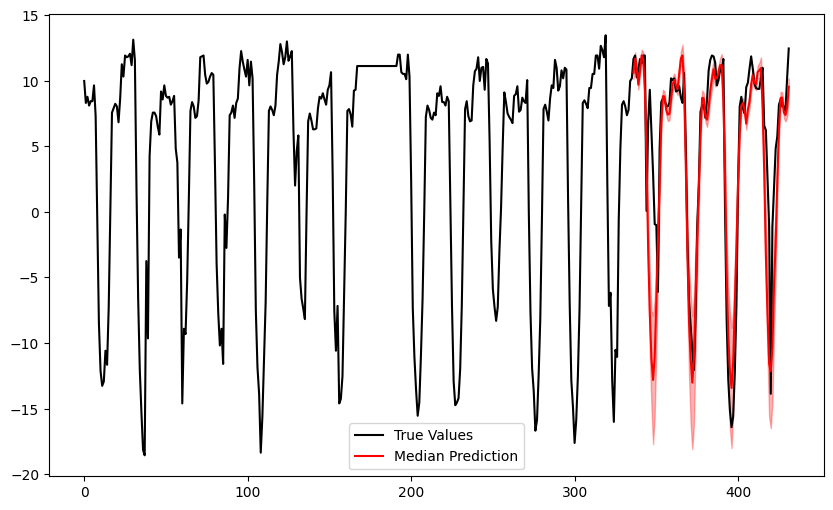

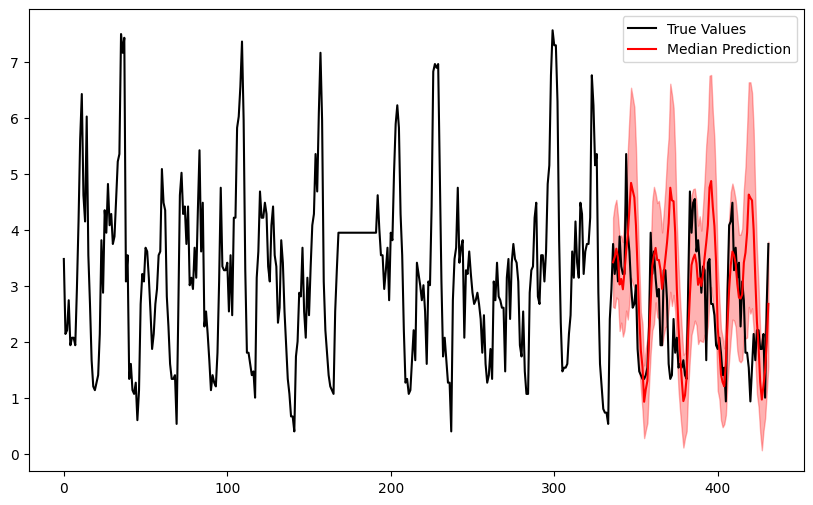

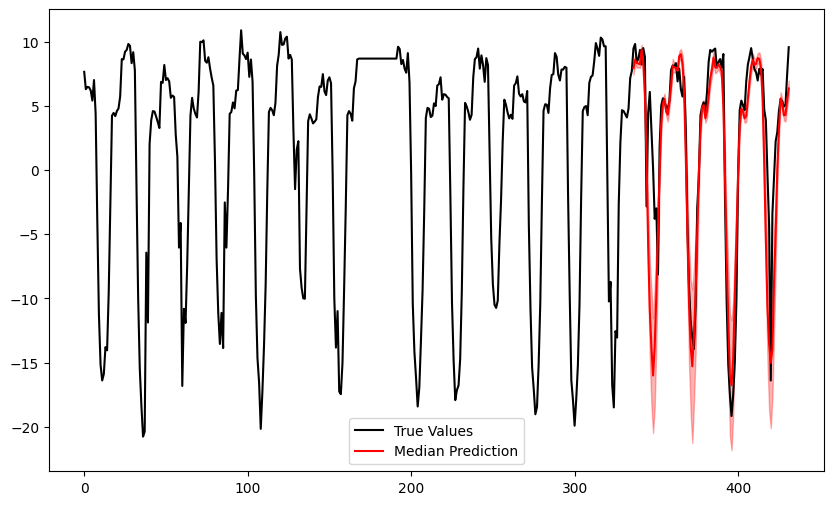

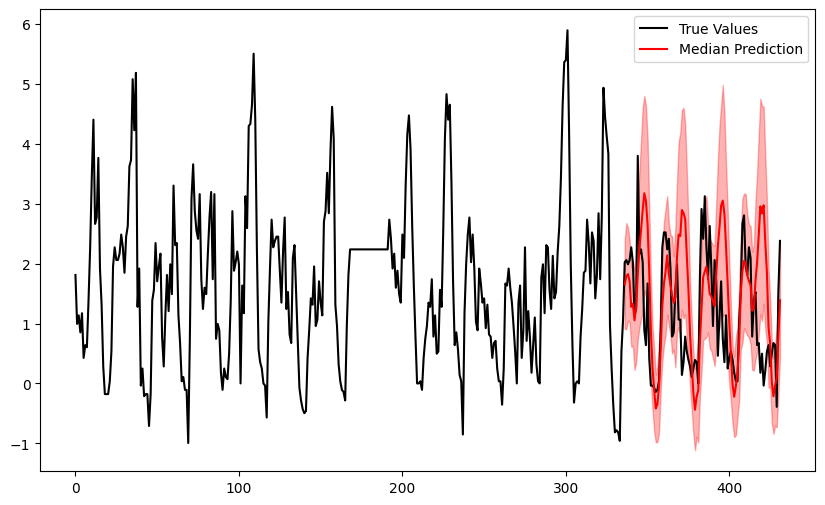

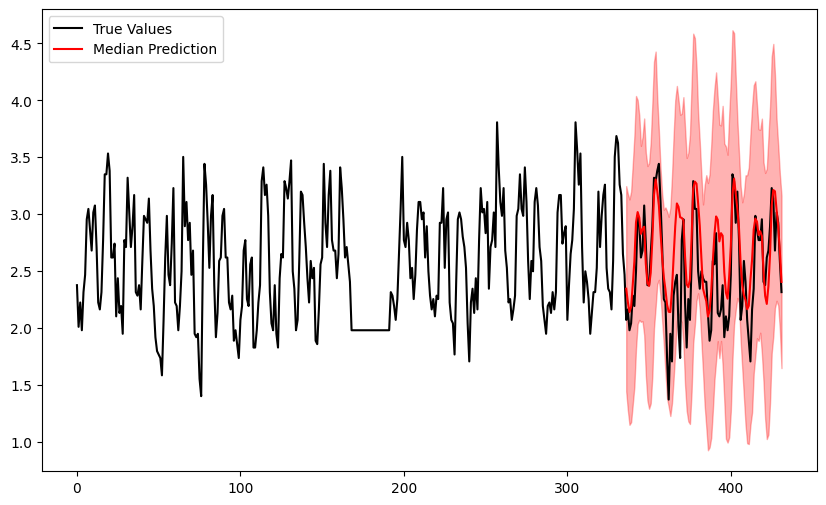

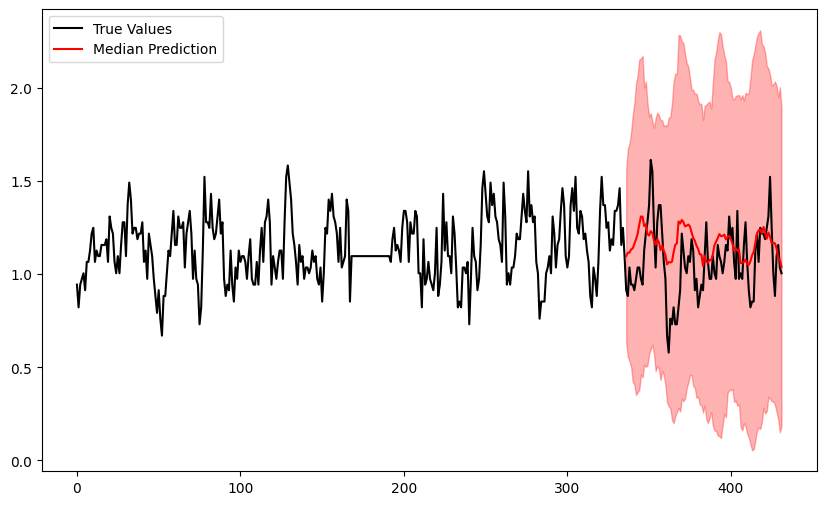

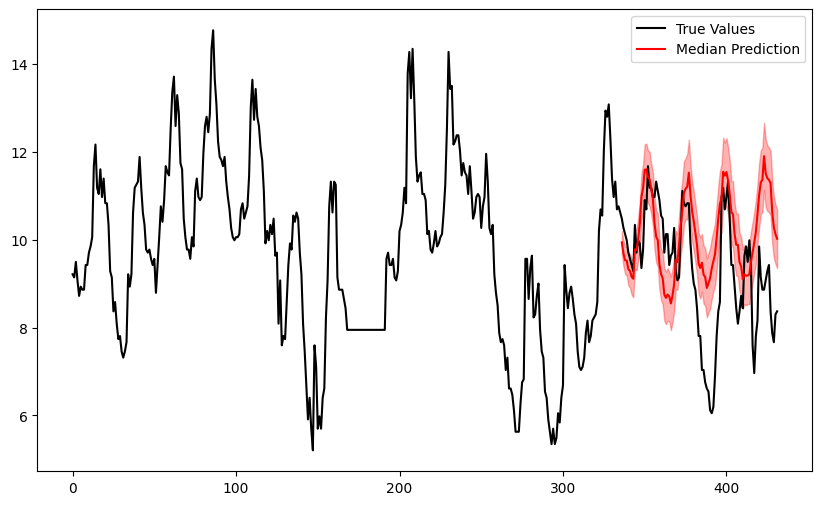

Model has outcome transform!


/home/kreffert/miniconda3/envs/BasicTS/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


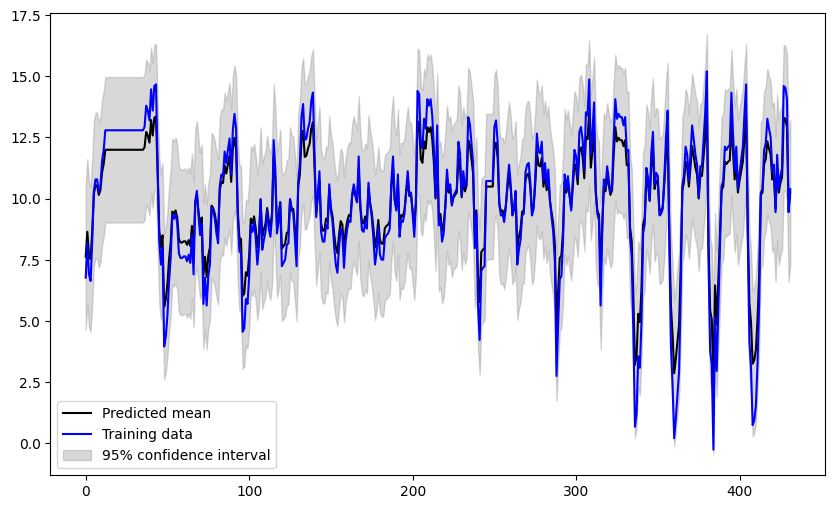

In [2]:
import torch
from torch.optim import SGD
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import SingleTaskGP
import gpytorch
from gpytorch.constraints import GreaterThan
from gpytorch.distributions import MultivariateNormal
import matplotlib.pyplot as plt
import seaborn as sns

class SeriesSampler_1:
    def __init__(self, gp_model, runner, num_samples=1):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gp_model = gp_model
        self.runner = runner
        self.base_model = runner.model 
        self.test_loader = runner.test_data_loader
        self.val_loader = runner.val_data_loader
        self.train_loader = runner.train_data_loader
        self.num_samples = num_samples

    def run(self):
        # 1. Fit the GP
        self.fit_gp()

        # 2. Make the predictions
        self.predictions = self.get_predictions_base_model(on='test')
        window = 0
        serie = 0
        mean_pred = self.predictions[window, :, serie, 0]  # Shape: [num_time_steps]
        std_pred = self.predictions[window, :, serie, 1]   # Shape: [num_time_steps]
        
        # 4. define new posterior
        self.new_posterior = self.init_distribution(mean_pred, std_pred)

        return self.sample(self.new_posterior)

    def get_batch(self, data_loader, first=True, window=0, series=0):
        if first:
            # select the first batch
            _iter = iter(data_loader) 
            batch = next(_iter)
        else:
            # select the last batch
            num_batches = len(data_loader)
            if num_batches == 0:
                return None, None
            _iter = iter(data_loader)
            for i in range(num_batches - 1):
                next(_iter)
            batch = next(_iter)

        history = batch['inputs'][..., :1]     # bs x length x num_series x features [33, 336, 7, 1]
        target = batch['target'][..., :1]     # bs x length x num_series x features [33, 336, 7, 1]
        targets = torch.cat([history, target], dim=1)  # batch_size, horizon, num_series = (32, 360, 7)
        targets = targets[window, :, series]  # only select first batch/window at first (360, num_series)
        horizon_length = targets.shape[0]
    
        x = torch.arange(horizon_length).to(self.device, dtype=torch.float32).unsqueeze(-1)  # [360, 1]
        y = targets.to(self.device, dtype=torch.float32)  # [360, num_series, 1]
        return x, y

    def fit_gp(self):
        x, y = self.get_batch(self.train_loader, first=False)
        self.gp_train_x, self.gp_train_y = x, y
        self.gp_model = self.gp_model(train_X=x, train_Y=y, 
                                      mean_module=gpytorch.means.ConstantMean())  # Disable automatic output standardization)
        
        # Register noise constraint
        self.gp_model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))
        
        mll = ExactMarginalLogLikelihood(likelihood=self.gp_model.likelihood, model=self.gp_model)
        # Set mll and all submodules to the specified dtype and device
        mll = mll.to(x.device)
    
        optimizer = SGD([{"params": self.gp_model.parameters()}], lr=0.025)
        NUM_EPOCHS = 600
    
        self.gp_model.train()
    
        for epoch in range(NUM_EPOCHS):
            optimizer.zero_grad()
            output = self.gp_model(x)
            loss = -mll(output, self.gp_model.train_targets)
            loss.backward()
            if (epoch + 1) % 100 == 0:
                print(
                    f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>4.3f} "
                    f"lengthscale: {self.gp_model.covar_module.lengthscale.item():>4.3f} "
                    f"noise: {self.gp_model.likelihood.noise.item():>4.3f}"
                )
            optimizer.step()

    def get_predictions_base_model(self, on='val'):
        self.base_model.eval()  # Ensure model is in eval mode
        self.base_model.to(self.device)  # Move to appropriate device
        predictions = []
        if on == 'val':
            dataloader = self.val_loader
        else: 
            dataloader = self.test_loader
        with torch.no_grad():
            for batch_idx, batch in tqdm(enumerate(dataloader)):
                # TODO scaler 
                model_return = self.runner.forward(batch, epoch=None, iter_num=None, train=False)
                if self.runner.scaler:
                    model_return['prediction'] = self.runner.scaler.inverse_transform(model_return['prediction'])
                    model_return['target'] = self.runner.scaler.inverse_transform(model_return['target'])
                    model_return['inputs'] = self.runner.scaler.inverse_transform(model_return['inputs'])
                #model_return = self.runner.postprocessing(model_return)
                #forecasts = model(batch['inputs'][..., :1].to(device), batch['target'].to(device), batch_seen=0, epoch=0, train=False)
                forecasts = model_return['prediction']
                predictions.append(forecasts)
        predictions = torch.cat(predictions, dim=0)
        return predictions

    def init_distribution(self, mean_pred, std_pred):
        x, y = self.get_batch(self.test_loader, first=True)
        
        self.gp_model.eval()  # Ensure model is in evaluation mode
        
        # Filter x to match the length of mean_pred
        x_filter = x[-len(mean_pred):]
        
        # 1. Compute the kernel covariance matrix for the filtered test points
        kernel_matrix = self.gp_model.covar_module(x_filter).evaluate()
        
        # 2. Adjust the covariance matrix using the standard deviation predictions
        updated_cov = kernel_matrix + torch.diag(std_pred**2)  # Convert std to variance and create diagonal covariance
        
        # 3. Construct the updated Multivariate Normal distribution
        new_posterior = MultivariateNormal(mean_pred, updated_cov)
        return new_posterior

    def sample(self, distribution):
        # Sample self.num_samples realization(s) from the adjusted GP
        new_sample = distribution.rsample(torch.Size([self.num_samples]))  # Shape: (num_samples, test_x.size(0))
        return new_sample

    def visualize_corr(self):
        # Get test data
        test_x, _ = self.get_batch(self.test_loader, first=True)
        
        # Compute kernel matrix
        kernel_matrix = self.gp_model.covar_module(test_x).evaluate()
        
        # Visualize correlation
        plt.figure(figsize=(8, 6))
        sns.heatmap(kernel_matrix.detach().to('cpu'), cmap="coolwarm", square=True, cbar=True)
        plt.title("Kernel Matrix Correlation")
        plt.show()

    def visualize_gp(self):
        self.gp_model.eval()
        self.gp_model.likelihood.eval()
        
        # Check if BoTorch model is standardizing outputs
        if hasattr(self.gp_model, 'outcome_transform'):
            print("Model has outcome transform!")
            # Untransform predictions if there is a transform
            outcome_transform = self.gp_model.outcome_transform
        else:
            outcome_transform = None
        
        # Get predictions
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            y_pred_dist = self.gp_model(self.gp_train_x)
            mean = y_pred_dist.mean
            lower, upper = y_pred_dist.confidence_region()
            
            # If there is an outcome transform, untransform the predictions
            if outcome_transform:
                mean, _ = outcome_transform.untransform(mean)
                lower, _ = outcome_transform.untransform(lower)
                upper, _ = outcome_transform.untransform(upper)
        
        # Reshape self.gp_train_x to match the shape of mean
        self.gp_train_x = self.gp_train_x.flatten()  # Flatten the x-values
        
        # Plot results
        plt.figure(figsize=(10, 6))
        plt.plot(self.gp_train_x.cpu(), mean.cpu().flatten(), 'k-', label='Predicted mean')  # Flatten the mean
        plt.plot(self.gp_train_x.cpu(), self.gp_train_y.cpu(), color='blue', label='Training data')
        plt.fill_between(self.gp_train_x.cpu().flatten(), 
                         lower.cpu().flatten(), 
                         upper.cpu().flatten(), 
                         color='gray', alpha=0.3, 
                         label='95% confidence interval')
        plt.legend()
        plt.show()

    def visualize_sample(self, num_samples=3, on='test'):
        # 1. plot the model predictions
        x, y = self.get_batch(self.test_loader, first=True)
        for series in range(7):
            window = 0
            x, y = self.get_batch(self.test_loader, first=True, window=window, series=series)
            mean_pred = self.predictions[window, :, series, 0]  # Shape: [num_time_steps]
            std_pred = self.predictions[window, :, series, 1]   # Shape: [num_time_steps]
            
            # 4. define new posterior
            lower_bound = mean_pred + 2*std_pred
            upper_bound = mean_pred - 2*std_pred 
    
            plt.figure(figsize=(10, 6))
            plt.plot(x.cpu().flatten(), y.cpu().flatten(), 'k-', label='True Values')  # Flatten the mean
            plt.plot(x[-len(mean_pred):].cpu().flatten(), mean_pred.cpu(), color='red', label="Median Prediction")
            plt.fill_between(x[-len(mean_pred):].cpu().flatten(), lower_bound.cpu(), upper_bound.cpu(), color='red', alpha=0.3)
            # Plot results
            plt.legend()
            plt.show()


        new_posterior = self.init_distribution(mean_pred, std_pred)
        sample = self.sample(new_posterior)
        self.gp_model.eval()
        self.gp_model.likelihood.eval()
        
        # Check if BoTorch model is standardizing outputs
        if hasattr(self.gp_model, 'outcome_transform'):
            print("Model has outcome transform!")
            # Untransform predictions if there is a transform
            outcome_transform = self.gp_model.outcome_transform
        else:
            outcome_transform = None
        
        # Get predictions
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            y_pred_dist = self.gp_model(self.gp_train_x)
            mean = y_pred_dist.mean
            lower, upper = y_pred_dist.confidence_region()
            
            # If there is an outcome transform, untransform the predictions
            if outcome_transform:
                mean, _ = outcome_transform.untransform(mean)
                lower, _ = outcome_transform.untransform(lower)
                upper, _ = outcome_transform.untransform(upper)
        
        # Reshape self.gp_train_x to match the shape of mean
        self.gp_train_x = self.gp_train_x.flatten()  # Flatten the x-values
        
        # Plot results
        plt.figure(figsize=(10, 6))
        plt.plot(self.gp_train_x.cpu(), mean.cpu().flatten(), 'k-', label='Predicted mean')  # Flatten the mean
        plt.plot(self.gp_train_x.cpu(), self.gp_train_y.cpu(), color='blue', label='Training data')
        plt.fill_between(self.gp_train_x.cpu().flatten(), 
                         lower.cpu().flatten(), 
                         upper.cpu().flatten(), 
                         color='gray', alpha=0.3, 
                         label='95% confidence interval')
        plt.legend()
        plt.show()
        
        
from botorch.models import SingleTaskGP
gp_model = SingleTaskGP
sampl = SeriesSampler_1(gp_model, runner, num_samples=1)
sampl.run()
#sampl.visualize_gp()
sampl.visualize_sample()

In [3]:
def get_batch(data_loader, first=True, window=0, series=0):
        if first:
            # select the first batch
            _iter = iter(data_loader) 
            batch = next(_iter)
        else:
            # select the last batch
            num_batches = len(data_loader)
            if num_batches == 0:
                return None, None
            _iter = iter(data_loader)
            for i in range(num_batches - 1):
                next(_iter)
            batch = next(_iter)

        history = batch['inputs'][..., :1]     # bs x length x num_series x features [33, 336, 7, 1]
        target = batch['target'][..., :1]     # bs x length x num_series x features [33, 336, 7, 1]
        targets = torch.cat([history, target], dim=1)  # batch_size, horizon, num_series = (32, 360, 7)
        targets = targets[window, :, series]  # only select first batch/window at first (360, num_series)
        horizon_length = targets.shape[0]
    
        x = torch.arange(horizon_length).to('cuda', dtype=torch.float32).unsqueeze(-1)  # [360, 1]
        y = targets.to('cuda', dtype=torch.float32)  # [360, num_series, 1]
        return x, y
    
def get_predictions_base_model(on='val', runner=None):
    runner.model.eval()  # Ensure model is in eval mode
    runner.model.to('cuda')  # Move to appropriate device
    predictions = []
    if on == 'val':
        dataloader = self.val_loader
    else: 
        dataloader = runner.test_data_loader
    with torch.no_grad():
        for batch_idx, batch in tqdm(enumerate(dataloader)):
            # TODO scaler 
            model_return = runner.forward(batch, epoch=None, iter_num=None, train=False)
            if runner.scaler:
                model_return['prediction'] = runner.scaler.inverse_transform(model_return['prediction'])
                model_return['target'] = runner.scaler.inverse_transform(model_return['target'])
                model_return['inputs'] = runner.scaler.inverse_transform(model_return['inputs'])
            #model_return = self.runner.postprocessing(model_return)
            #forecasts = model(batch['inputs'][..., :1].to(device), batch['target'].to(device), batch_seen=0, epoch=0, train=False)
            forecasts = model_return['prediction']
            predictions.append(forecasts)
    predictions = torch.cat(predictions, dim=0)
    return predictions

runner = init(model='PatchTST', dataset='ETTh1', no_logging=True)
predictions = get_predictions_base_model(on='test', runner=runner)
for series in range(7):
    window = 0
    x, y = get_batch(runner.test_data_loader, first=True, window=window, series=series)
    pred = predictions[window, :, series]  # Shape: [num_time_steps]
    
    plt.figure(figsize=(10, 6))
    plt.plot(x.cpu().flatten(), y.cpu().flatten(), 'k-', label='True Values')  # Flatten the mean
    plt.plot(x[-len(pred):].cpu().flatten(), pred.cpu(), color='red', label="Median Prediction")
    plt.legend()
    plt.show()

DESCRIPTION: An Example Config
GPU_NUM: 1
RUNNER: <class 'basicts.runners.runner_zoo.simple_tsf_runner.SimpleTimeSeriesForecastingRunner'>
DATASET:
  NAME: ETTh1
  TYPE: <class 'basicts.data.simple_tsf_dataset.TimeSeriesForecastingDataset'>
  PARAM:
    dataset_name: ETTh1
    train_val_test_ratio: [0.6, 0.2, 0.2]
    input_len: 336
    output_len: 336
SCALER:
  TYPE: <class 'basicts.scaler.z_score_scaler.ZScoreScaler'>
  PARAM:
    dataset_name: ETTh1
    train_ratio: 0.6
    norm_each_channel: True
    rescale: False
MODEL:
  NAME: PatchTST
  ARCH: <class 'baselines.PatchTST.arch.patchtst_arch.PatchTST'>
  PARAM:
    enc_in: 7
    seq_len: 336
    pred_len: 336
    e_layers: 3
    n_heads: 4
    d_model: 16
    d_ff: 128
    dropout: 0.3
    fc_dropout: 0.3
    head_dropout: 0.0
    patch_len: 16
    stride: 8
    individual: 0
    padding_patch: end
    revin: 1
    affine: 0
    subtract_last: 0
    decomposition: 0
    kernel_size: 25
  FORWARD_FEATURES: [0]
  TARGET_FEATURES: [0]

RuntimeError: Error(s) in loading state_dict for PatchTST:
	Missing key(s) in state_dict: "model.head.linear.weight", "model.head.linear.bias". 
	Unexpected key(s) in state_dict: "model.head.prob_heads.0.mean.weight", "model.head.prob_heads.0.mean.bias", "model.head.prob_heads.0.std.weight", "model.head.prob_heads.0.std.bias", "model.head.prob_heads.1.mean.weight", "model.head.prob_heads.1.mean.bias", "model.head.prob_heads.1.std.weight", "model.head.prob_heads.1.std.bias", "model.head.prob_heads.2.mean.weight", "model.head.prob_heads.2.mean.bias", "model.head.prob_heads.2.std.weight", "model.head.prob_heads.2.std.bias", "model.head.prob_heads.3.mean.weight", "model.head.prob_heads.3.mean.bias", "model.head.prob_heads.3.std.weight", "model.head.prob_heads.3.std.bias", "model.head.prob_heads.4.mean.weight", "model.head.prob_heads.4.mean.bias", "model.head.prob_heads.4.std.weight", "model.head.prob_heads.4.std.bias", "model.head.prob_heads.5.mean.weight", "model.head.prob_heads.5.mean.bias", "model.head.prob_heads.5.std.weight", "model.head.prob_heads.5.std.bias", "model.head.prob_heads.6.mean.weight", "model.head.prob_heads.6.mean.bias", "model.head.prob_heads.6.std.weight", "model.head.prob_heads.6.std.bias". 